In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import batch_norm
from torchvision import datasets, transforms, utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import ssl
import random

ssl._create_default_https_context = ssl._create_stdlib_context

In [14]:
# Ensure reproducibility

# Set a global random seed
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

In [15]:
lr = 0.001
batch_size = 128
n_channels, w, h = 1, 28, 28
max_epochs = 5


In [16]:
from pathlib import Path



dt_p = Path('data/mnist')

classes = [str(i) for i in range(10)]
n_labels = len(classes)

transform = transforms.Compose(
    [transforms.ToTensor()])


trainset = datasets.MNIST(root=f'{dt_p.absolute()}/train', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = datasets.MNIST(root=f'{dt_p.absolute()}/test', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)


In [17]:


class Net(nn.Module):
    def __init__(self, input_size=28):  # Add input size for flexibility
        super().__init__()
        self.conv1a = nn.Conv2d(1, 32, 3, padding=0)
        self.conv1b = nn.Conv2d(32, 32, 3, padding=0)
        self.conv2a = nn.Conv2d(32, 64, 3, padding=0)
        self.conv2b = nn.Conv2d(64, 64, 3, padding=0)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute the number of features dynamically
        self._to_linear = self._get_conv_output(input_size)

        self.fc1 = nn.Linear(self._to_linear, 200)
        self.fc2 = nn.Linear(200, 10)

        self.flatten = nn.Flatten()
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(200)  # Now correctly applied

    def _get_conv_output(self, size):
        """Helper function to compute the output size after convolutions"""
        x = torch.zeros(1, 1, size, size)  # Create a dummy tensor
        x = self.pool(F.relu(self.conv1b(F.relu(self.conv1a(x)))))
        x = self.pool(F.relu(self.conv2b(F.relu(self.conv2a(x)))))
        return x.numel()

    def forward(self, x):
        x = self.activation(self.conv1a(x))
        x = self.activation(self.conv1b(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.activation(self.conv2a(x))
        x = self.activation(self.conv2b(x))
        x = self.dropout(x)
        x = self.pool(x)

        x = self.flatten(x)  # Flatten before FC layers
        x = self.activation(self.fc1(x))
        x = self.batchnorm(x)
        x = self.fc2(x)
        # CrossEntropyLoss already applied softmax
        return x  # Remove softmax if using CrossEntropyLoss

    
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Playing on {device}")

Playing on mps


In [18]:
# Specify teacher model

teacher_model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(teacher_model.parameters(), lr=lr)

 20%|██        | 1/5 [00:03<00:12,  3.15s/it]

Epoch 0: 0.1005193293094635


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


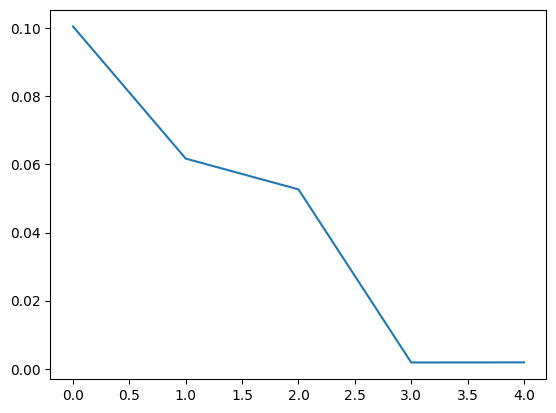

RuntimeError: Parent directory models does not exist.

In [19]:
# Train the teacher model
teacher_losses = []

for e in tqdm(range(max_epochs)):
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        logits = teacher_model(images)

        # Compute loss
        loss = criterion(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    teacher_losses.append(loss.item())

    if e % 10 == 0 or e == max_epochs:
        print(f"Epoch {e}: {loss.item()}")

# Save trained teacher model
torch.save(teacher_model.state_dict(), "teacher_model.pth")

PATH = f'models/mnist_model_lr.pth'
torch.save(teacher_model.state_dict(), PATH)


In [ ]:
plt.plot(teacher_losses)
plt.show()

In [58]:
# Generate Soft Labels

temp = 1.0

def get_soft_labels(model, dataloader, temp):
    soft_labels_list = []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            # Get logits from trained teacher model
            logits = model(images)
            # Apply temperature-scaled softmax
            soft_labels = torch.softmax(logits / temp, dim=1)
            soft_labels_list.append(soft_labels.cpu())
    return torch.cat(soft_labels_list)

# Generate soft labels for training the student
soft_labels = get_soft_labels(teacher_model, trainloader, temp)

In [62]:
max_epochs = 25

In [63]:
# Initialize the student model
student_model = Net().to(device)
student_optimizer = optim.AdamW(student_model.parameters(), lr=lr)

kl_loss = nn.KLDivLoss(reduction="batchmean")  # KL Divergence loss

student_losses = []

for e in tqdm(range(max_epochs)):
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)

        # Get soft labels from precomputed list
        soft_target = soft_labels[i * batch_size : (i + 1) * batch_size].to(device)

        # Forward pass
        student_logits = student_model(images)

        # Apply log-softmax to student model logits (for KLDivLoss)
        student_probs = torch.log_softmax(student_logits / temp, dim=1)

        # Compute KL divergence loss between student and teacher soft labels
        loss = kl_loss(student_probs, soft_target)

        # Backward pass
        student_optimizer.zero_grad()
        loss.backward()
        student_optimizer.step()

    student_losses.append(loss.item())

    if e % 10 == 0 or e == max_epochs:
        print(f"Epoch {e}: {loss.item()}")

# Save trained student model
torch.save(student_model.state_dict(), "student_model.pth")


  4%|▍         | 1/25 [00:03<01:20,  3.35s/it]

Epoch 0: 2.2414023876190186


 44%|████▍     | 11/25 [00:35<00:44,  3.17s/it]

Epoch 10: 2.274482011795044


 84%|████████▍ | 21/25 [01:07<00:13,  3.32s/it]

Epoch 20: 2.2681286334991455


100%|██████████| 25/25 [01:20<00:00,  3.22s/it]


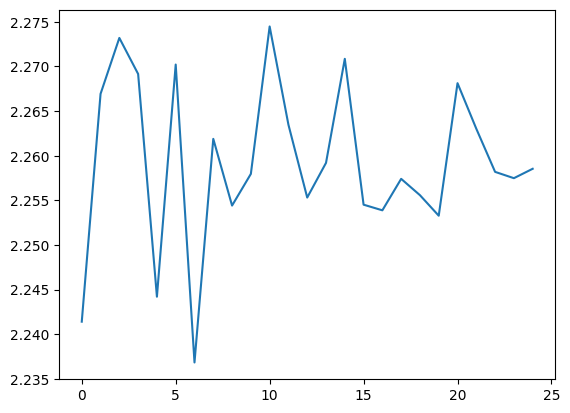

In [64]:
plt.plot(student_losses)
plt.show()

## Direction Sensitivity Estimation
This section aims to experiment with the first of the two tasks [(Papernot et al., 2016)](https://arxiv.org/abs/1511.04508): Direction Sensitivity Estimation. Given a sample $X$ we want to test a trained model $F$ on perturbated version of the sample (i.e. $\delta X$) to find the dimensions of $X$ that will produce expected adversarial behavior (misclassification) with the *smallest* perturbation. We formalize the problem as a linear program:
$$\arg\min_{\delta X}||\delta X|| \text{ s.t. } F(X+\delta X) = Y^*$$
where $Y^*$ is the adverserial class indicator vector. Following [(Goodfellow et al., 2014)](https://arxiv.org/pdf/1412.6572) we calculate the sign of the gradient (i.e. `step = images.grad.sign()`) and after defining a perturbation of $\delta = 0.2$ and calculate the loss for both vanilla and perturbated sample to study the loss.

In [52]:
delta = 0.2

In [53]:
# Get a batch of test images
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)
images.requires_grad = True  # Enable gradients for attack


### Evaluate the Teacher Model on Clean Images
labels_hat_teacher = teacher_model(images)
loss_teacher = criterion(labels_hat_teacher, labels)
loss_teacher.backward()
print("Teacher Model - Original Loss:", loss_teacher.item())

# Generate Adversarial Images (FGSM Attack)
step = images.grad.sign()  # Compute gradient sign
perturbed_images = images + delta * step  # Apply perturbation
perturbed_images = torch.clamp(perturbed_images, 0, 1)  # Keep within valid range

# Evaluate Teacher Model on Adversarial Images
labels_hat_teacher_adv = teacher_model(perturbed_images)
loss_teacher_adv = criterion(labels_hat_teacher_adv, labels)
print("Teacher Model - Adversarial Loss:", loss_teacher_adv.item())


Teacher Model - Original Loss: 0.03400265797972679
Teacher Model - Adversarial Loss: 2.0632870197296143


In [54]:
# Evaluate Student Model on Clean Images**
labels_hat_student = student_model(images)
loss_student = criterion(labels_hat_student, labels)
print("Student Model - Original Loss:", loss_student.item())

# Evaluate Student Model on Adversarial Images**
labels_hat_student_adv = student_model(perturbed_images)
loss_student_adv = criterion(labels_hat_student_adv, labels)
print("Student Model - Adversarial Loss:", loss_student_adv.item())

# Predictions Before and After Attack**
_, pred_teacher = torch.max(labels_hat_teacher, 1)
_, pred_teacher_adv = torch.max(labels_hat_teacher_adv, 1)

_, pred_student = torch.max(labels_hat_student, 1)
_, pred_student_adv = torch.max(labels_hat_student_adv, 1)

Student Model - Original Loss: 2.3270528316497803
Student Model - Adversarial Loss: 2.3276705741882324


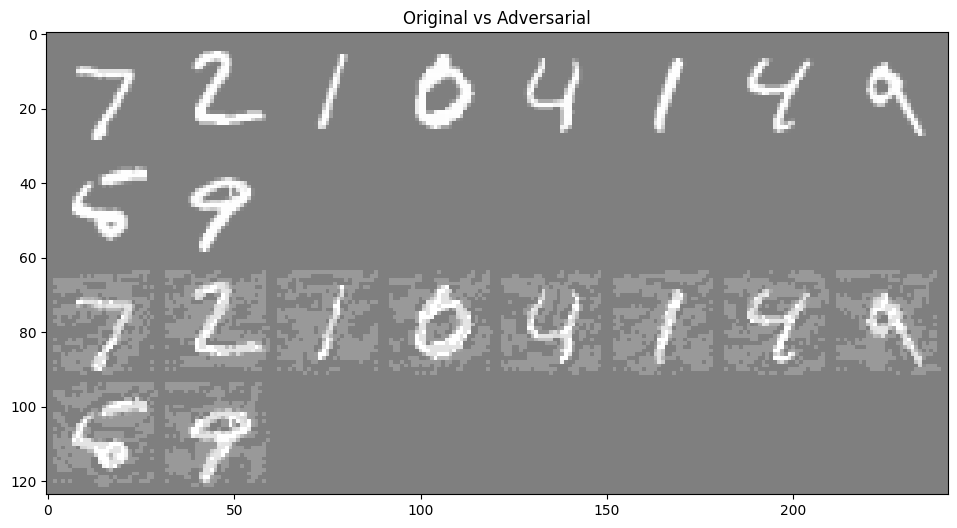


Teacher Model Attack Results: fail fail succ succ succ fail succ succ succ succ fail succ succ fail succ succ succ fail succ succ succ succ fail fail succ succ succ fail succ succ fail fail succ succ fail succ fail fail fail fail fail succ succ succ fail succ fail fail succ succ succ fail fail fail succ fail succ fail succ succ succ succ succ succ fail succ succ succ fail succ fail fail succ succ fail fail succ succ succ fail fail fail succ fail fail succ fail succ succ succ fail succ succ fail succ succ succ fail succ succ succ fail succ succ succ succ succ succ fail fail succ succ fail succ succ errr succ succ succ succ succ succ succ fail fail succ succ fail

Student Model Attack Results: fail errr errr errr errr errr errr errr errr errr errr errr errr errr errr errr errr errr errr errr errr errr errr errr errr errr fail errr errr errr errr errr errr errr errr errr errr errr errr fail errr errr errr errr errr errr fail errr errr errr errr errr errr errr errr errr errr errr errr err

In [55]:
### **7️⃣ Visualizing the Attack Effect**
limit = 10  # Limit number of images displayed

# Convert images for visualization
grid_clean = utils.make_grid(images[:limit].cpu()) / 2 + 0.5
grid_adv = utils.make_grid(perturbed_images[:limit].cpu()) / 2 + 0.5

# Concatenate clean and adversarial images for visualization
combined_grid = np.concatenate((np.transpose(grid_clean.numpy(), (1, 2, 0)),
                                np.transpose(grid_adv.numpy(), (1, 2, 0))))


# Show the images
plt.figure(figsize=(12, 6))
plt.imshow(combined_grid)
plt.title("Original vs Adversarial")
plt.show()

### **8️⃣ Attack Success Analysis**
def attack_results(pred_clean, pred_adv, labels):
    results = []
    for o, p, a in zip(pred_clean.cpu(), labels.cpu(), pred_adv.cpu()):
        if o != p:
            results.append("errr")  # Model was already incorrect
        elif o == p and o != a:
            results.append("succ")  # Attack successful (changed prediction)
        else:
            results.append("fail")  # Attack failed (model remained correct)
    return results

teacher_attack_results = attack_results(pred_teacher, pred_teacher_adv, labels)
student_attack_results = attack_results(pred_student, pred_student_adv, labels)

print("\nTeacher Model Attack Results:", ' '.join(teacher_attack_results))
print("\nStudent Model Attack Results:", ' '.join(student_attack_results))

print(f"\n🔥 Delta Loss Comparison:")
print(f"   Teacher:   Original = {loss_teacher.item():.4f}, Adversarial = {loss_teacher_adv.item():.4f}, Δ = {abs(loss_teacher.item() - loss_teacher_adv.item()):.4f}")
print(f"   Student:   Original = {loss_student.item():.4f}, Adversarial = {loss_student_adv.item():.4f}, Δ = {abs(loss_student.item() - loss_student_adv.item()):.4f}")


In [56]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
accuracies = []
with torch.no_grad():
    for _ in tqdm(range(10)):
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = teacher_model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracies.append(100 * correct / total)

print(f'Accuracy of the network on the 10000 test images: {np.mean(accuracies):.3f} %')

100%|██████████| 10/10 [00:03<00:00,  2.93it/s]

Accuracy of the network on the 10000 test images: 99.040 %


In [57]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
accuracies = []
with torch.no_grad():
    for _ in tqdm(range(10)):
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = student_model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracies.append(100 * correct / total)

print(f'Accuracy of the network on the 10000 test images: {np.mean(accuracies):.3f} %')

100%|██████████| 10/10 [00:03<00:00,  2.53it/s]

Accuracy of the network on the 10000 test images: 7.446 %



🔍 Testing delta = 0.1
   Teacher Δ Loss: 0.4049 | Student Δ Loss: 0.0003

🔍 Testing delta = 0.2
   Teacher Δ Loss: 2.0293 | Student Δ Loss: 0.0006

🔍 Testing delta = 0.3
   Teacher Δ Loss: 3.8562 | Student Δ Loss: 0.0007

🔍 Testing delta = 0.4
   Teacher Δ Loss: 4.8907 | Student Δ Loss: 0.0014

🔍 Testing delta = 0.5
   Teacher Δ Loss: 5.4115 | Student Δ Loss: 0.0013

🔍 Testing delta = 0.6
   Teacher Δ Loss: 5.6177 | Student Δ Loss: 0.0025


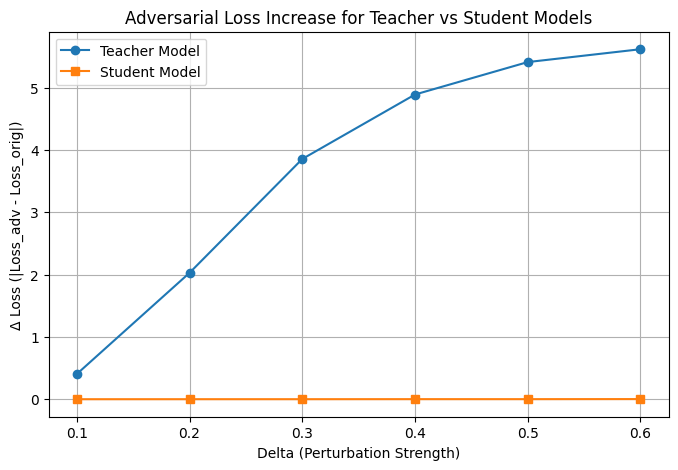

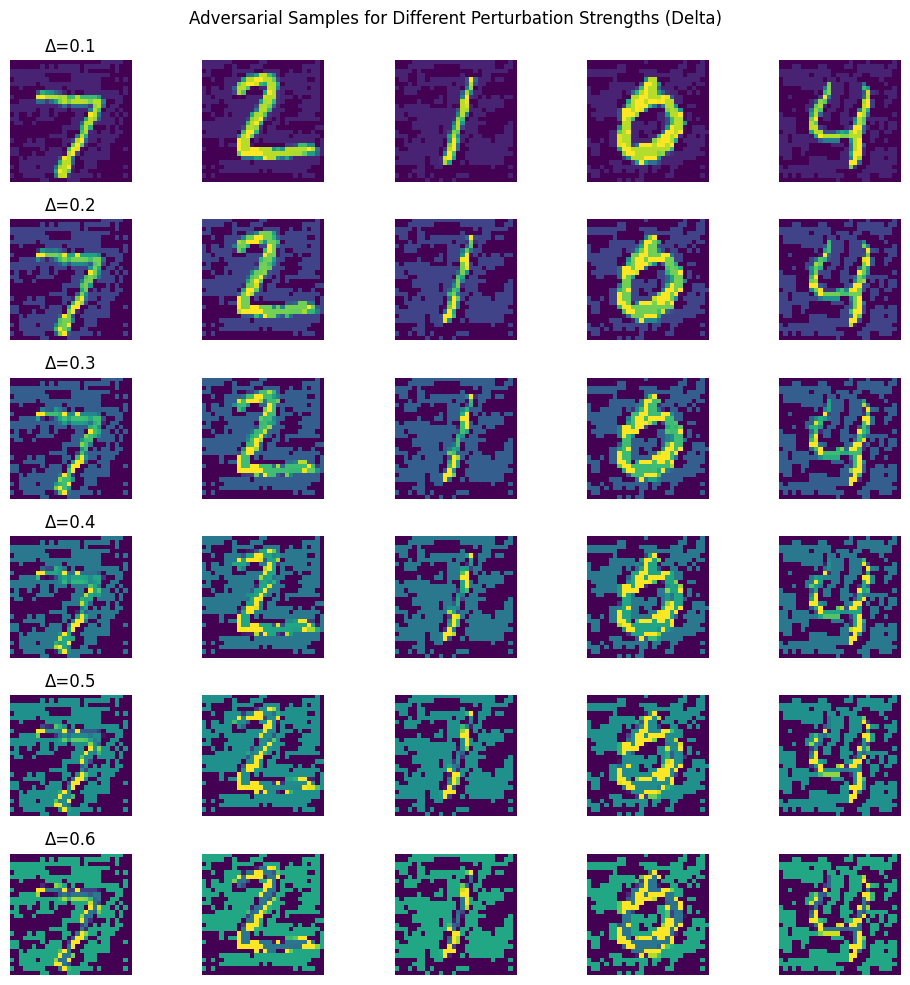

In [66]:
# Define delta values to test
delta_values = np.arange(0.1, 0.7, 0.1)  # From 0.1 to 0.6 with step of 0.1
teacher_losses, student_losses = [], []

# Get a batch of test images
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

# Store adversarial examples for visualization
adv_examples = {}

### **Loop Over Delta Values**
for delta in delta_values:
    print(f"\n🔍 Testing delta = {delta:.1f}")

    images.requires_grad = True  # Enable gradients for attack

    # **1️⃣ Forward pass for teacher model on clean images**
    labels_hat_teacher = teacher_model(images)
    loss_teacher = criterion(labels_hat_teacher, labels)
    loss_teacher.backward()

    # **2️⃣ Generate Adversarial Images (FGSM Attack)**
    step = images.grad.sign()
    perturbed_images = images + delta * step  # Apply perturbation
    perturbed_images = torch.clamp(perturbed_images, 0, 1)  # Keep within valid range

    # **3️⃣ Evaluate Teacher Model on Adversarial Images**
    labels_hat_teacher_adv = teacher_model(perturbed_images)
    loss_teacher_adv = criterion(labels_hat_teacher_adv, labels)

    # **4️⃣ Evaluate Student Model on Clean & Adversarial Images**
    labels_hat_student = student_model(images)
    loss_student = criterion(labels_hat_student, labels)

    labels_hat_student_adv = student_model(perturbed_images)
    loss_student_adv = criterion(labels_hat_student_adv, labels)

    # Store loss differences
    teacher_losses.append(abs(loss_teacher.item() - loss_teacher_adv.item()))
    student_losses.append(abs(loss_student.item() - loss_student_adv.item()))

    print(f"   Teacher Δ Loss: {teacher_losses[-1]:.4f} | Student Δ Loss: {student_losses[-1]:.4f}")

    # Store adversarial examples (5 samples per delta)
    adv_examples[delta] = perturbed_images[:5].cpu()

### **📊 Plot Loss vs Delta Comparison**
plt.figure(figsize=(8, 5))
plt.plot(delta_values, teacher_losses, marker='o', label="Teacher Model")
plt.plot(delta_values, student_losses, marker='s', label="Student Model")
plt.xlabel("Delta (Perturbation Strength)")
plt.ylabel("Δ Loss (|Loss_adv - Loss_orig|)")
plt.title("Adversarial Loss Increase for Teacher vs Student Models")
plt.legend()
plt.grid(True)
plt.show()

### **📸 Visualize Adversarial Examples for Different Delta Values**
fig, axes = plt.subplots(len(delta_values), 5, figsize=(10, 10))

for i, delta in enumerate(delta_values):
    for j in range(5):  # 5 samples per delta
        img = adv_examples[delta][j].detach().numpy().transpose((1, 2, 0))
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(f"Δ={delta:.1f}")

plt.suptitle("Adversarial Samples for Different Perturbation Strengths (Delta)")
plt.tight_layout()
plt.show()